# ICL 20/21 - ML Algorithm Fairness Coursework

### Setup

In [ ]:
!pip install 'aif360[LFR]'

In [7]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas/

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas


In [ ]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

In [9]:
from aif360.datasets import CompasDataset

In [10]:
#Import the libraries and set the random seed.

import numpy as np
import math
import copy

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

import pdb

from sklearn.preprocessing import StandardScaler  #MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import *

SEED = 0
np.random.seed(SEED)

In [11]:
#We define where's the bias in the features of our dataset.
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
dataset_orig = load_preproc_data_compas(['race'])

#We split between training and test set.
train, test = dataset_orig.split([0.9], shuffle=True)

# split the train set into 10 folds for cross-validation
folds = 10
folds_data = train.split(folds) # list of 10 sub-sets of type Dataset (not np)

scale_orig = StandardScaler()
scaler = scale_orig.fit(train.features) # fit a scaler on all the train data

# get the test data ready for later
X_test = scaler.transform(test.features)
y_test = test.labels.ravel()

### Task 1

#### Logistic regression: CV

In [12]:
# Actual cross-validation

C_params = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6,1e-5, 
            1e-4, 1e-3,1e-2, 1e-1, 1, 1e2, 1e5, 1e10,] 
metric_arrs = dict()

for c in C_params:
    metric_arrs[str(c)] = dict()
    metric_arrs[str(c)]['acc'] = []
    metric_arrs[str(c)]['bal_acc'] = []
    metric_arrs[str(c)]['disp_imp'] = []
    metric_arrs[str(c)]['stat_par_diff'] = []
    metric_arrs[str(c)]['eq_opp_diff'] = []
    metric_arrs[str(c)]['avg_odds_diff'] = []

    for i in range(folds):
        # set aside a validation fold
        val = folds_data[i]
        labels_val = folds_data[i].labels.ravel()

        # concatenate the remaining folds to get the train set
        to_concat = folds_data[:i] + folds_data[i+1 :]
        concat_labels = [data.labels.ravel() for data in to_concat]
        to_concat = [scaler.transform(data.features) for data in to_concat]

        train_np = np.concatenate(to_concat, axis=0)
        train_wo_protected = np.delete(train_np, 0, 1)
        train_labels = np.concatenate(concat_labels)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_wo_protected, train_labels)

        # make predictions on the validation set and save tem as Dataset labels
        val_wo_protected = np.delete(scaler.transform(val.features), 0, 1)
        predictions = learner.predict(val_wo_protected)
        val_pred = val.copy()
        val_pred.labels = predictions

        metric_arrs[str(c)]['acc'].append(sum(predictions==labels_val)/len(labels_val))

        metric = ClassificationMetric(val, val_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [13]:
cv_results = dict()

for key in metric_arrs.keys():
    cv_results[key] = dict()
    for key_2 in metric_arrs[key].keys():
        cv_results[key][key_2] = sum(metric_arrs[key][key_2])/len(metric_arrs[key][key_2])

for key in cv_results.keys():
    print('{:.2e}'.format(float(key)), cv_results[key])

1.00e-15 {'acc': 0.6517894736842106, 'bal_acc': 0.6489162629915877, 'disp_imp': 0.5545723144523039, 'stat_par_diff': -0.338241540674309, 'eq_opp_diff': -0.2834479464677089, 'avg_odds_diff': -0.3040706882592644}
1.00e-10 {'acc': 0.6517894736842106, 'bal_acc': 0.6489162629915877, 'disp_imp': 0.5545723144523039, 'stat_par_diff': -0.338241540674309, 'eq_opp_diff': -0.2834479464677089, 'avg_odds_diff': -0.3040706882592644}
1.00e-09 {'acc': 0.6517894736842106, 'bal_acc': 0.6489162629915877, 'disp_imp': 0.5545723144523039, 'stat_par_diff': -0.338241540674309, 'eq_opp_diff': -0.2834479464677089, 'avg_odds_diff': -0.3040706882592644}
1.00e-08 {'acc': 0.6517894736842106, 'bal_acc': 0.6489162629915877, 'disp_imp': 0.5545723144523039, 'stat_par_diff': -0.338241540674309, 'eq_opp_diff': -0.2834479464677089, 'avg_odds_diff': -0.3040706882592644}
1.00e-07 {'acc': 0.6517894736842106, 'bal_acc': 0.6489162629915877, 'disp_imp': 0.5545723144523039, 'stat_par_diff': -0.338241540674309, 'eq_opp_diff': -0.2

In [14]:
acc = []
bal_acc = []
disp_imp = []
stat_par = []
eq_op = []
avg_odds = []

for key in cv_results.keys():
    acc.append(cv_results[key]['acc'])
    bal_acc.append(cv_results[key]['bal_acc'])
    disp_imp.append(cv_results[key]['disp_imp'])
    stat_par.append(cv_results[key]['stat_par_diff'])
    eq_op.append(cv_results[key]['eq_opp_diff'])
    avg_odds.append(cv_results[key]['avg_odds_diff'])

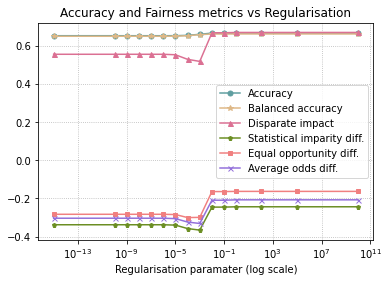

In [15]:
import matplotlib.pyplot as plt

plt.plot(C_params, acc, color='cadetblue', marker = "o", markersize=5, label = "Accuracy")
plt.plot(C_params, bal_acc, color = 'burlywood', marker = "*",markersize=6, label = "Balanced accuracy")
plt.plot(C_params, disp_imp, color= 'palevioletred', marker ="^", markersize=5, label = "Disparate impact")
plt.plot(C_params, stat_par, color = 'olivedrab', marker = "p", markersize=5, label = "Statistical imparity diff.")
plt.plot(C_params, eq_op, color = 'lightcoral', marker = "s", markersize=4, label = "Equal opportunity diff.")
plt.plot(C_params, avg_odds,color='mediumpurple', marker = "x", markersize=5, label = "Average odds diff.")
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.xscale("log")
plt.xlabel("Regularisation paramater (log scale)")
plt.title("Accuracy and Fairness metrics vs Regularisation")
plt.show()

#### Final model evaluation

In [16]:
# Evaluating final model

metric_arrs = dict()
final_cs = [1e-2, 1e-6]

for c in final_cs:
    for seed in range(5):
        SEED = seed
        np.random.seed(SEED)

        metric_arrs[str(c)] = dict()
        metric_arrs[str(c)]['acc'] = []
        metric_arrs[str(c)]['bal_acc'] = []
        metric_arrs[str(c)]['disp_imp'] = []
        metric_arrs[str(c)]['stat_par_diff'] = []
        metric_arrs[str(c)]['eq_opp_diff'] = []
        metric_arrs[str(c)]['avg_odds_diff'] = []
        
        train_labels = train.labels.ravel()
        train_np = scaler.transform(train.features)
        train_wo_protected = np.delete(train_np, 0, 1)
        

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_wo_protected, train_labels)

        # make predictions on the validation set and save tem as Dataset labels
        test_wo_protected = np.delete(X_test, 0, 1)
        predictions = learner.predict(test_wo_protected)
        test_pred = test.copy()
        test_pred.labels = predictions

        metric_arrs[str(c)]['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

        metric = ClassificationMetric(test, test_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [17]:
cv_results = dict()

for key in metric_arrs.keys():
    cv_results[key] = dict()
    for key_2 in metric_arrs[key].keys():
        cv_results[key][key_2] = sum(metric_arrs[key][key_2])/len(metric_arrs[key][key_2])

for key in cv_results.keys():
    print('{:.2e}'.format(float(key)), cv_results[key])

1.00e-02 {'acc': 0.6761363636363636, 'bal_acc': 0.6695218061578803, 'disp_imp': 0.7455621301775147, 'stat_par_diff': -0.18376068376068377, 'eq_opp_diff': -0.16480331262939962, 'avg_odds_diff': -0.1711157843500199}
1.00e-06 {'acc': 0.6325757575757576, 'bal_acc': 0.6276168109844829, 'disp_imp': 0.6282051282051282, 'stat_par_diff': -0.27884615384615385, 'eq_opp_diff': -0.3119047619047619, 'avg_odds_diff': -0.2654998423210344}


In [18]:
# set seed back to what it was originally
SEED = 0

### Task 2

#### Logistic regression: CV

In [19]:
# Actual cross-validation

C_params = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,1e-2, 1e-1, 
            1, 1e2, 1e3, 1e4, 1e5, 1e7,1e8,1e9, 1e10, 1e15] 
f_metric_arrs = dict()

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

reweights = RW.fit(train)

for c in C_params:
    f_metric_arrs[str(c)] = dict()
    f_metric_arrs[str(c)]['acc'] = []
    f_metric_arrs[str(c)]['bal_acc'] = []
    f_metric_arrs[str(c)]['disp_imp'] = []
    f_metric_arrs[str(c)]['stat_par_diff'] = []
    f_metric_arrs[str(c)]['eq_opp_diff'] = []
    f_metric_arrs[str(c)]['avg_odds_diff'] = []

    for i in range(folds):
        # set aside a validation fold
        val = folds_data[i]
        labels_val = folds_data[i].labels.ravel()

        # concatenate the remaining folds to get the train set
        to_concat = folds_data[:i] + folds_data[i+1 :]
        concat_labels = [data.labels.ravel() for data in to_concat]
        w_to_concat = [(reweights.transform(data)).instance_weights for data in to_concat]
        to_concat = [scaler.transform(data.features) for data in to_concat]

        train_np = np.concatenate(to_concat, axis=0)
        train_weights = np.concatenate(w_to_concat, axis=0)
        train_labels = np.concatenate(concat_labels)
        train_wo_protected = np.delete(train_np, 0, 1)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_wo_protected, train_labels, sample_weight=train_weights)

        # make predictions on the validation set and save tem as Dataset labels
        val_wo_protected = np.delete(scaler.transform(val.features), 0, 1)
        predictions = learner.predict(val_wo_protected)
        val_pred = val.copy()
        val_pred.labels = predictions

        f_metric_arrs[str(c)]['acc'].append(sum(predictions==labels_val)/len(labels_val))

        metric = ClassificationMetric(val, val_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        f_metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        f_metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        f_metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        f_metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        f_metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [20]:
f_cv_results = dict()

for key in f_metric_arrs.keys():
    f_cv_results[key] = dict()
    for key_2 in f_metric_arrs[key].keys():
        f_cv_results[key][key_2] = sum(f_metric_arrs[key][key_2])/len(f_metric_arrs[key][key_2])

for key in f_cv_results.keys():
    print('{:.2e}'.format(float(key)), f_cv_results[key])

1.00e-15 {'acc': 0.6461052631578947, 'bal_acc': 0.6464634965324302, 'disp_imp': 0.6732889892422498, 'stat_par_diff': -0.20619177123097004, 'eq_opp_diff': -0.16494701565713593, 'avg_odds_diff': -0.1685211392377585}
1.00e-10 {'acc': 0.6461052631578947, 'bal_acc': 0.6464634965324302, 'disp_imp': 0.6732889892422498, 'stat_par_diff': -0.20619177123097004, 'eq_opp_diff': -0.16494701565713593, 'avg_odds_diff': -0.1685211392377585}
1.00e-09 {'acc': 0.6461052631578947, 'bal_acc': 0.6464634965324302, 'disp_imp': 0.6732889892422498, 'stat_par_diff': -0.20619177123097004, 'eq_opp_diff': -0.16494701565713593, 'avg_odds_diff': -0.1685211392377585}
1.00e-08 {'acc': 0.6461052631578947, 'bal_acc': 0.6464634965324302, 'disp_imp': 0.6732889892422498, 'stat_par_diff': -0.20619177123097004, 'eq_opp_diff': -0.16494701565713593, 'avg_odds_diff': -0.1685211392377585}
1.00e-07 {'acc': 0.6461052631578947, 'bal_acc': 0.6464634965324302, 'disp_imp': 0.6732889892422498, 'stat_par_diff': -0.20619177123097004, 'eq_o

In [21]:
r_acc = []
r_bal_acc = []
r_disp_imp = []
r_stat_par = []
r_eq_op = []
r_avg_odds = []

for key in f_cv_results.keys():
    r_acc.append(f_cv_results[key]['acc'])
    r_bal_acc.append(f_cv_results[key]['bal_acc'])
    r_disp_imp.append(f_cv_results[key]['disp_imp'])
    r_stat_par.append(f_cv_results[key]['stat_par_diff'])
    r_eq_op.append(f_cv_results[key]['eq_opp_diff'])
    r_avg_odds.append(f_cv_results[key]['avg_odds_diff'])

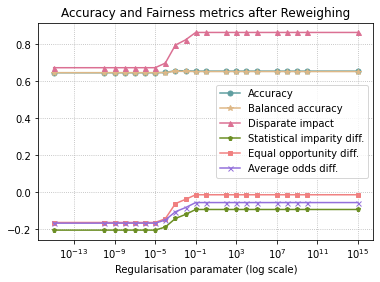

In [22]:
import matplotlib.pyplot as plt

plt.plot(C_params, r_acc, color='cadetblue', marker = "o", markersize=5, label = "Accuracy")
plt.plot(C_params, r_bal_acc, color = 'burlywood', marker = "*",markersize=6, label = "Balanced accuracy")
plt.plot(C_params, r_disp_imp, color= 'palevioletred', marker ="^", markersize=5, label = "Disparate impact")
plt.plot(C_params, r_stat_par, color = 'olivedrab', marker = "p", markersize=5, label = "Statistical imparity diff.")
plt.plot(C_params, r_eq_op, color = 'lightcoral', marker = "s", markersize=4, label = "Equal opportunity diff.")
plt.plot(C_params, r_avg_odds,color='mediumpurple', marker = "x", markersize=5, label = "Average odds diff.")
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.xscale("log")
plt.xlabel("Regularisation paramater (log scale)")
plt.title("Accuracy and Fairness metrics after Reweighing")
plt.show()

#### Final model evaluation

In [23]:
# Final model evaluation

C_params = [1e-3, 1e-5] 
f_metric_arrs = dict()

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

reweights = RW.fit_transform(train)

for c in C_params:
    f_metric_arrs[str(c)] = dict()
    f_metric_arrs[str(c)]['acc'] = []
    f_metric_arrs[str(c)]['bal_acc'] = []
    f_metric_arrs[str(c)]['disp_imp'] = []
    f_metric_arrs[str(c)]['stat_par_diff'] = []
    f_metric_arrs[str(c)]['eq_opp_diff'] = []
    f_metric_arrs[str(c)]['avg_odds_diff'] = []
    for SEED in range(5):

        train_labels = train.labels.ravel()
        train_np = scaler.transform(train.features)
        train_wo_protected = np.delete(train_np, 0, 1)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_wo_protected , train_labels, sample_weight = reweights.instance_weights)

        # make predictions on the test set and save tem as Dataset labels
        train_wo_protected = np.delete(X_test, 0, 1)
        predictions = learner.predict(train_wo_protected)
        test_pred = test.copy()
        test_pred.labels = predictions

        f_metric_arrs[str(c)]['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

        metric = ClassificationMetric(test, test_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        f_metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        f_metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        f_metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        f_metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        f_metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [24]:
cv_results = dict()

for key in f_metric_arrs.keys():
    cv_results[key] = dict()
    for key_2 in f_metric_arrs[key].keys():
        cv_results[key][key_2] = sum(f_metric_arrs[key][key_2])/len(f_metric_arrs[key][key_2])

for key in cv_results.keys():
    print('{:.2e}'.format(float(key)), cv_results[key])

# for key in f_metric_arrs.keys():
#     for key_2 in f_metric_arrs[key].keys():
#         print(key)
#         print(f_metric_arrs[key][key_2])

1.00e-03 {'acc': 0.6704545454545454, 'bal_acc': 0.6624692033944704, 'disp_imp': 0.7943786982248521, 'stat_par_diff': -0.14850427350427353, 'eq_opp_diff': -0.13995859213250517, 'avg_odds_diff': -0.1355146161545528}
1.00e-05 {'acc': 0.625, 'bal_acc': 0.6234385580705116, 'disp_imp': 0.75947187141217, 'stat_par_diff': -0.1492165242165242, 'eq_opp_diff': -0.1785714285714286, 'avg_odds_diff': -0.13633317565436773}
